### This project demostrates a variety of  regression approaches in estimating the ultimate recovery of horizontal multifractured wells (commonly the core task of the reservoir engineer, and critical to the business function of any exploration & production company).

### This notebook generates synthetic data that will be utilized in the various approached to modeling & prediction, and ends with some basic exploratory data analysis.

#### Contents:
    1) Imports & Settings
    2) Data Generation
    3) Exploratory Data Analysis

---
## 1) Imports & Settings

In [1]:
# import relevant modules:

# import os

# import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy.optimize import curve_fit, differential_evolution, minimize
# from scipy.stats import skew

# import statsmodels.api as sm

# from sklearn.metrics import mean_absolute_error, mean_squared_error
# from sklearn.linear_model import QuantileRegressor


# settings:

plt.rcParams['figure.figsize'] = (12,7)
plt.rcParams['figure.dpi'] = 300
sns.set()

---
# 2) Data Generation

### The generating phenomena are based on the fundamental physics of an oil reservoir under primary recovery by depletion / solution-gas drive.

### Populations are created for the following parameters:
- spacing, distance between laterals wellbores, perpendicular to wellbore (ft)
- phi, porosity (decimal)
- h, reservoir height (ft)
- Sw, water saturation (decimal)
- RF, recovery factor (decimal)

### These parameters will be used in generating the target variable:
- eurpft, estimated ultimate recovery (EUR) per foot of laterally drilled wellbore (barrels oil / ft)

using the simple volumetric recovery equation:<br>

    Recoverable Oil = 7758 * phi * h * (1-Sw) * RF / (43560 * Boi)

    Where Boi (Oil Formation Volume Factor) is assumed to equal 1.3, and the constants are unit conversion factors.

More on this method:
https://wiki.aapg.org/Reserves_estimation

### The target variable will be directly influenced by completion volumes:
- compl_bbl_per_ft, the amount of fracturing fluid pumped per foot of laterally drilled wellbore (barrels / ft)
- compl_sd_conc, the concentration of fracturing sand (proppant) carried in the fracturing fluid (lbs / barrel)

In [2]:
# the number of synthetic wells to be generated:
n = 1000
# I'll use an unusually high well count for ease of validity testing.
# Later phases of the project will address the reality of low sample counts.

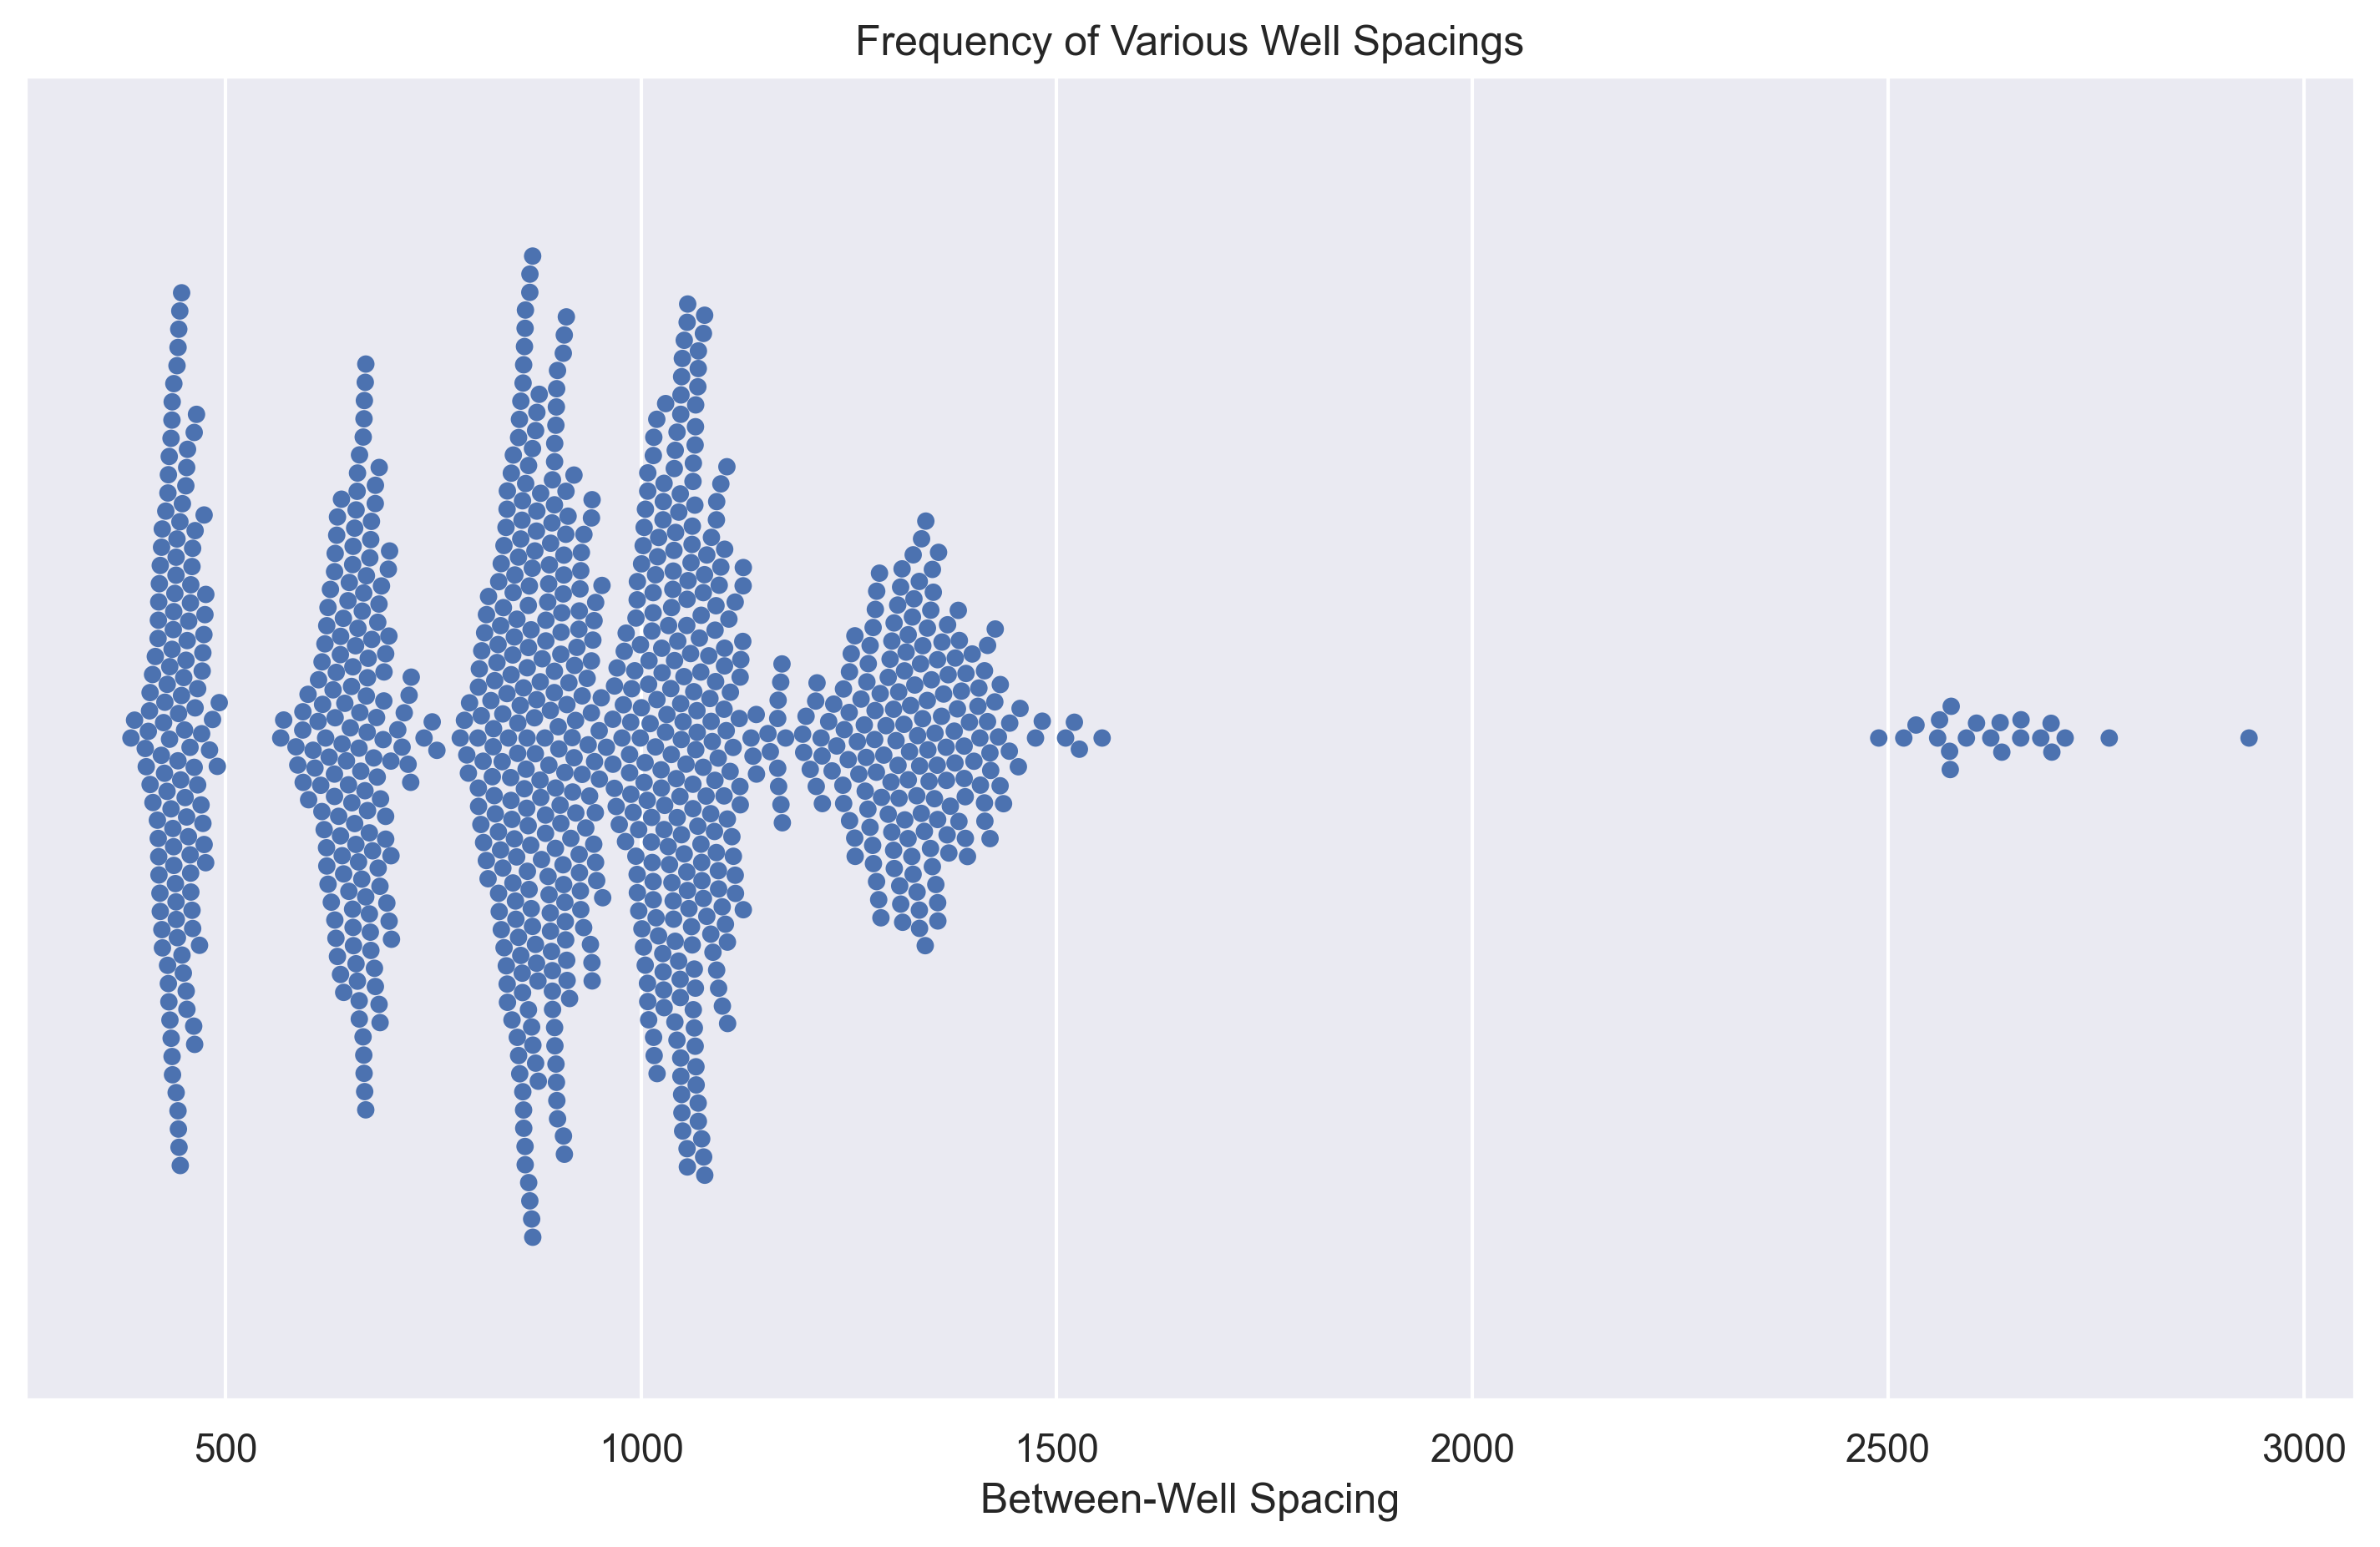

In [3]:
# add n fake wells at various spacings:

spacing = np.random.choice(np.concatenate([np.repeat(440, 6), 
                          np.repeat(660, 8),
                          np.repeat(880, 12), 
                          np.repeat(1056, 10),
                          np.repeat(1320, 8),
                          np.repeat(2640, 1)]), size=n)

# add small random noise to the individual wells spacings:
spacing = spacing * np.random.normal(1, .05, n)

spacing = np.sort(spacing)

sns.swarmplot(x=spacing)
plt.xlabel('Between-Well Spacing')
plt.title('Frequency of Various Well Spacings');

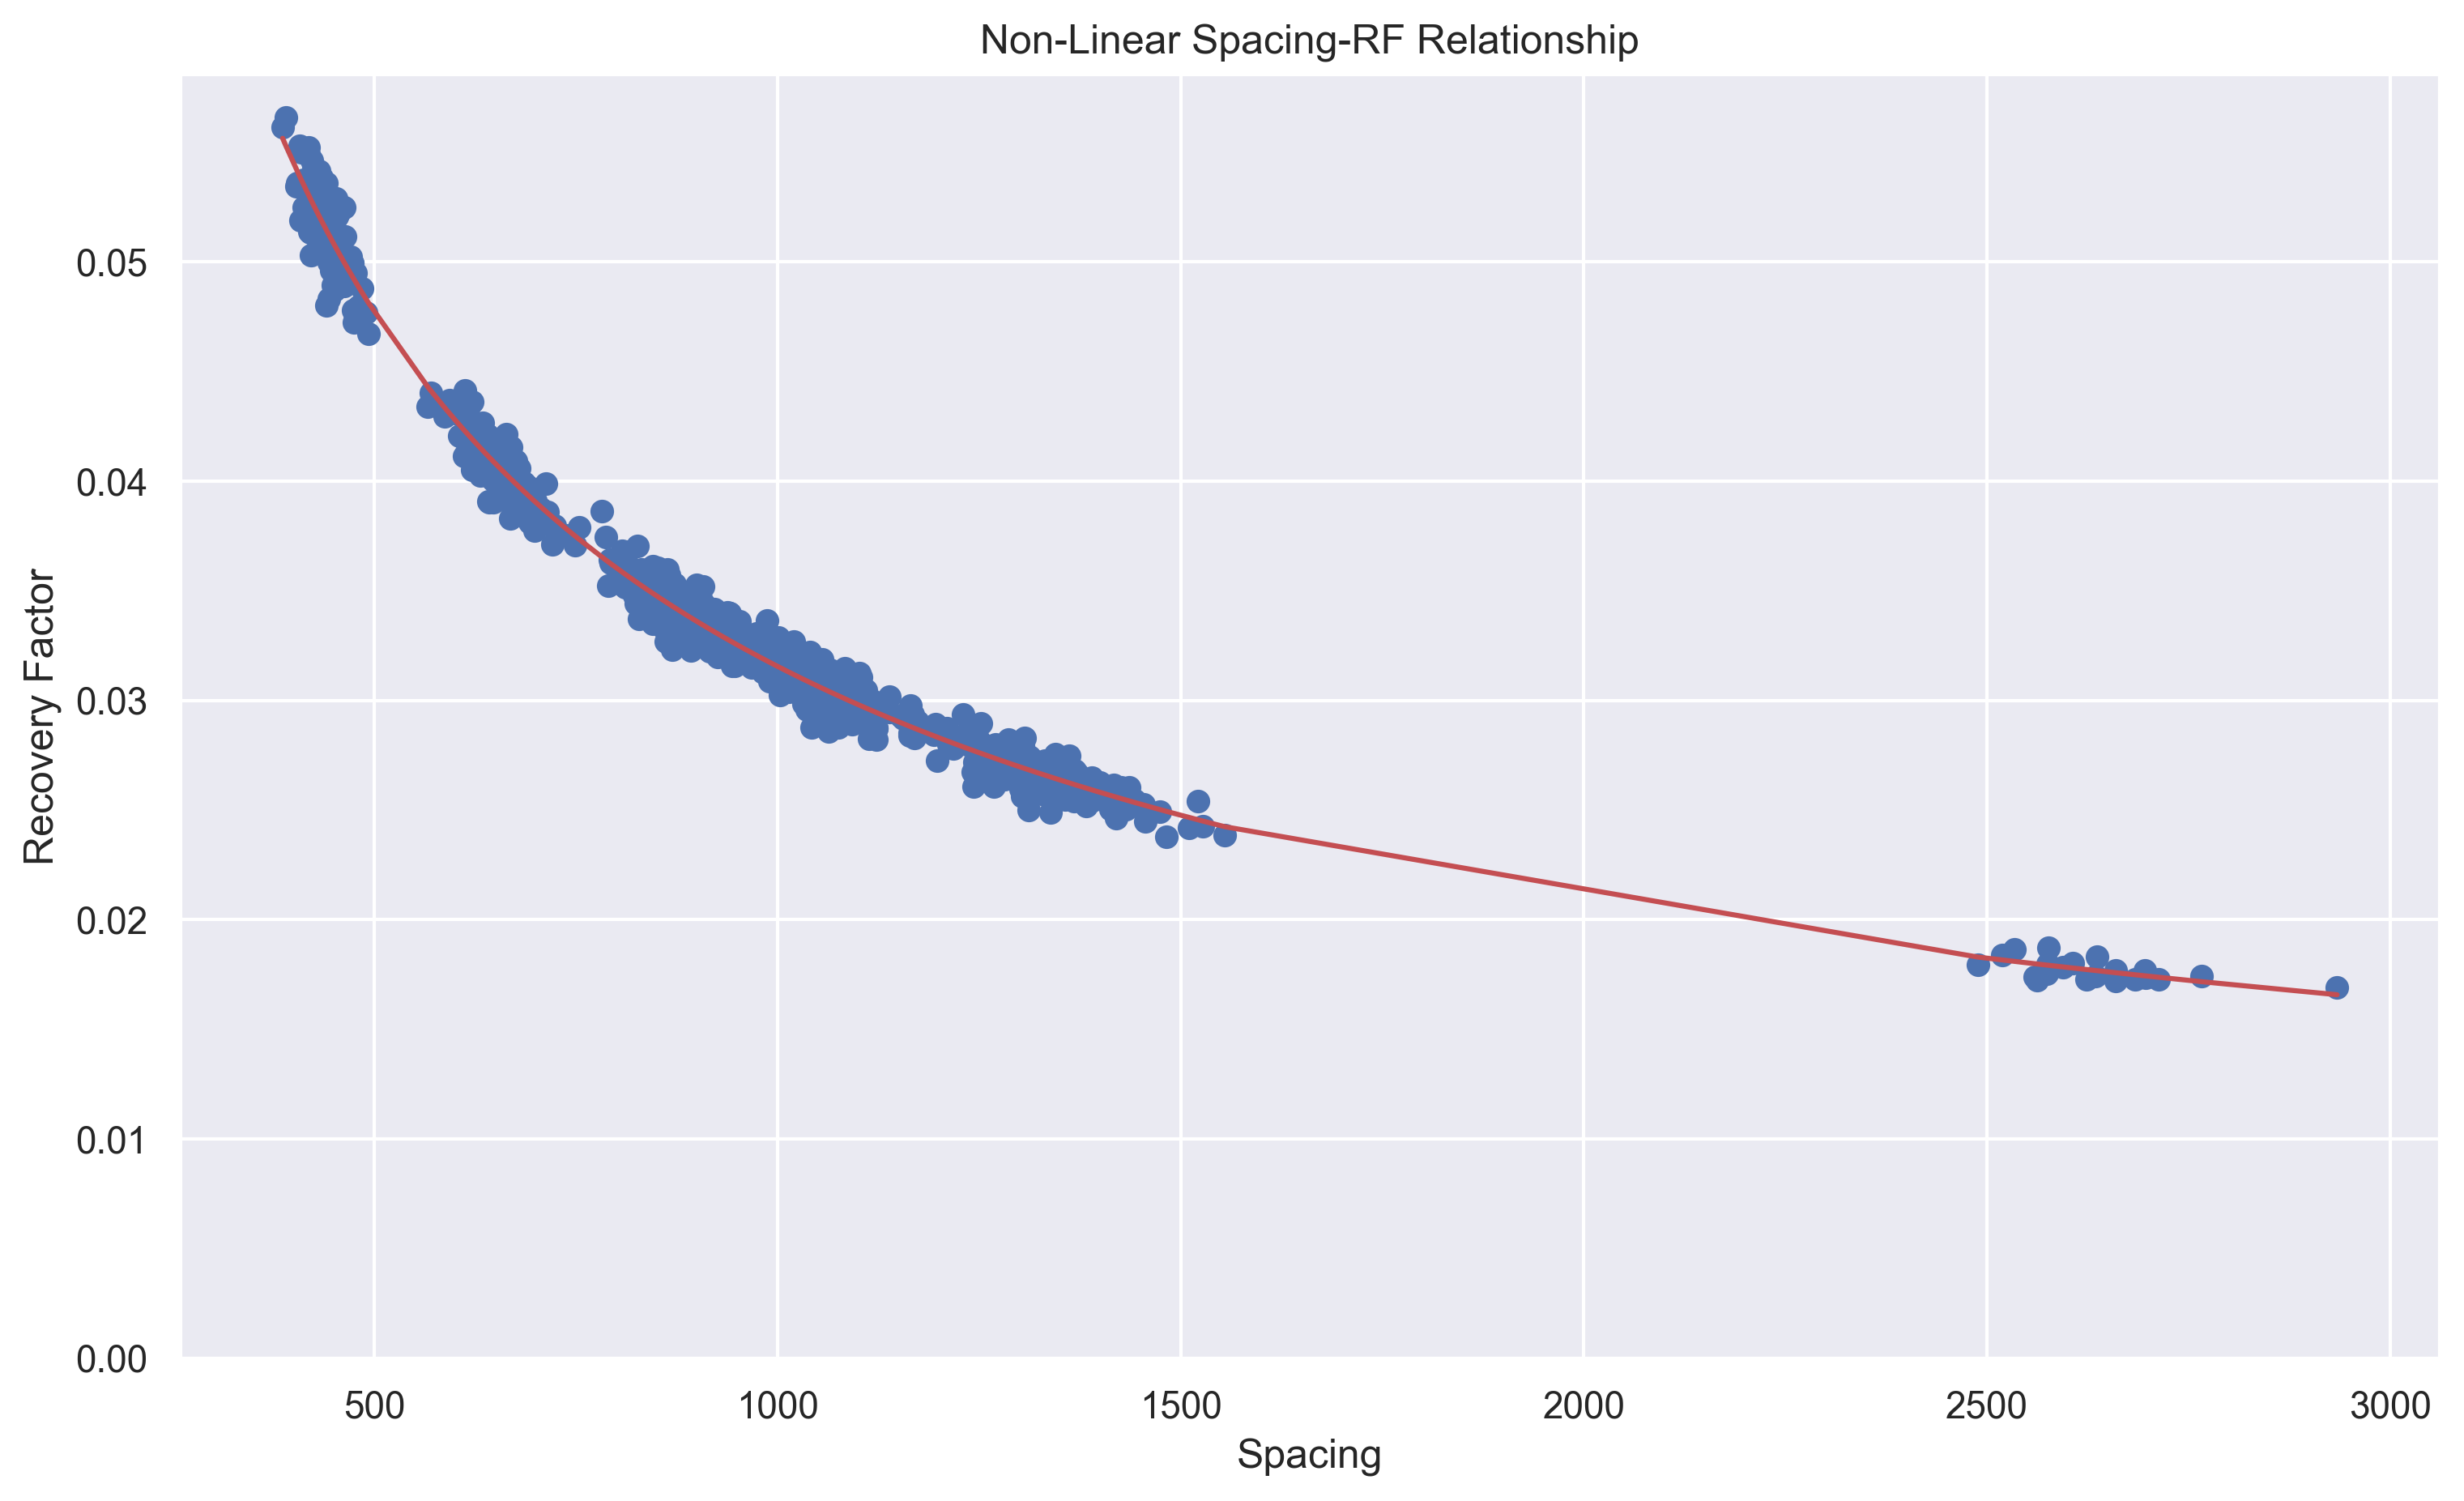

In [4]:
# generate the RF values based on a non-linear decreasing relationship to 
# spacing, based on the assumption that increased well density (decreased
# well spacing) results in higher recovery factors:

# RF0 = .1/(spacing**.2 + 0.3) + .1/(spacing**.2) - 0.0
RF0 = 2/(spacing**.6 + 0.3)
RF_noise = np.random.normal(loc=1, scale=0.02, size=n)
RF = RF0 * RF_noise

plt.plot(spacing, RF0, c='r')
plt.scatter(x=spacing, y=RF)
plt.ylim(0,)
plt.xlabel('Spacing')
plt.ylabel('Recovery Factor')
plt.title('Non-Linear Spacing-RF Relationship');

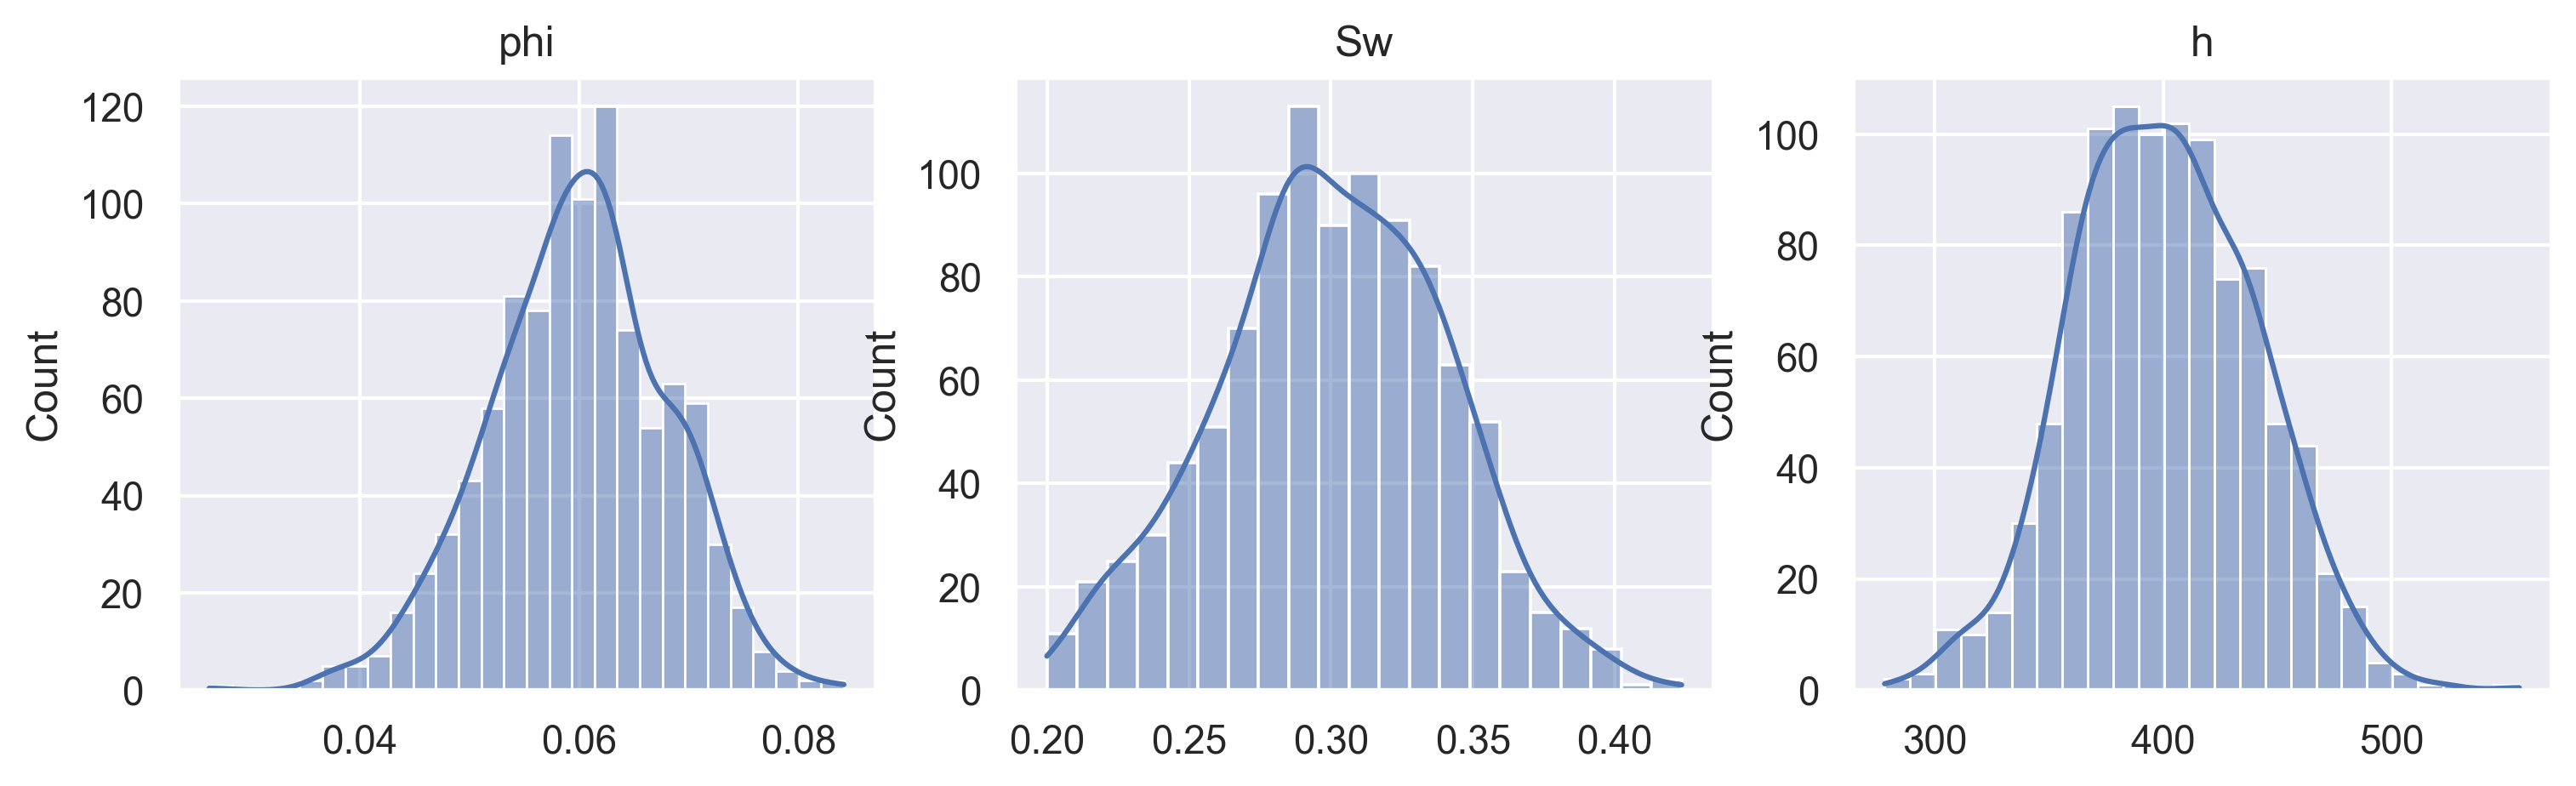

In [5]:
# finally, create the phi, Sw, and h distributions that reflect commonly observed real data:

phi = np.random.normal(loc=.06, scale=.008, size=n).clip(min=0.01)
Sw = np.random.normal(loc=.3, scale=.04, size=n).clip(min=0.2, max=.7)
h = np.random.normal(loc=400, scale=40, size=n).clip(min=0)

ax1 = plt.subplot(231)
ax1 = sns.histplot(phi, kde=True)
plt.title('phi')
ax2 = plt.subplot(232)
ax2 = sns.histplot(Sw, kde=True)
plt.title('Sw')
ax3 = plt.subplot(233)
ax3 = sns.histplot(h, kde=True)
plt.title('h');

In [6]:
# create a dafatframe for ease of viewing and manipulation:

df = pd.DataFrame({'spacing': spacing,
                  'phi': phi,
                  'Sw': Sw,
                  'h': h,
                  'RF': RF})


df.describe().T

,count,mean,std,min,25%,50%,75%,max
spacing,1000.0,950.604575,372.148973,386.255399,683.006079,919.629315,1092.784172,2934.249232
phi,1000.0,0.059892,0.008077,0.026263,0.054717,0.060123,0.065116,0.084148
Sw,1000.0,0.300298,0.040384,0.200000,0.274264,0.300026,0.329152,0.423486
h,1000.0,400.448241,39.862640,278.027874,371.908578,399.362940,429.773821,555.786736
RF,1000.0,0.034735,0.008077,0.016898,0.029617,0.033038,0.039292,0.056562


In [7]:
# populate fake completions fluid volumes, defaulting to ~45 bbl/ft:
df['compl_bbl_per_ft'] = np.random.choice([45,45,45,45,45,33,31,35,52,55,65,72], size=n)

# add small random noise to the compl. fluid vols:
df['compl_bbl_per_ft'] = df['compl_bbl_per_ft'] + np.random.normal(1, 1, n)

# populate completion sand concentration as a random choice between three concentration rates (lbs 
# sand per bbls compl fluid) options, with a 3/5 preference for 40 lbs/bbl:
df['compl_sd_conc'] = np.random.choice([30, 40, 40, 40, 50], n)

# Add a sand load (lbs compl sand per foot) column. This is for familiar
# viewing only. Generally fluid load (lbs fluid / ft) and sand load (lbs sd per foot)
# will have problematic multicollinearity, so sand load will be omitted in the regression
# in favor of sand concentration.
df['compl_lbs_sd_per_ft'] = df['compl_bbl_per_ft'] * df['compl_sd_conc']

df.head(10)

,spacing,phi,Sw,h,RF,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft
0,386.255399,0.062740,0.237485,406.079626,0.056124,46.041657,40,1841.666283
1,390.585776,0.056187,0.373563,367.600971,0.056562,32.008638,40,1280.345504
2,403.415561,0.047203,0.240518,465.391631,0.053450,31.768025,40,1270.720998
3,404.662535,0.065634,0.304776,398.489363,0.053586,58.350442,40,2334.017666
4,407.119056,0.041268,0.320917,380.122548,0.055297,46.897130,40,1875.885204
5,408.598673,0.053126,0.282460,368.533061,0.051899,71.141757,40,2845.670293
6,409.264070,0.061070,0.317427,370.673218,0.053402,51.472834,40,2058.913362
7,409.287416,0.059448,0.235750,419.157335,0.054974,46.051352,40,1842.054086
8,412.235126,0.045384,0.292439,404.923291,0.053740,32.855516,40,1314.220654
9,412.723164,0.060285,0.275478,403.679565,0.052479,45.856954,30,1375.708629


### Populate the EUR data & add noise

In [8]:
# adjust the RF by 10% for 25% change in sand concentration:
sd_conc_factor = 0.1 / .25

# adjust the RF by 10% for every 20% change in compl fluid per ft:
fluid_pft_factor = 0.2 / .25

df['RF'] = (1 + ((df['compl_sd_conc'] - 40) / 40) * (sd_conc_factor)) * df['RF']
df['RF'] = (1 + ((df['compl_bbl_per_ft'] - 45) / 45) * (fluid_pft_factor)) * df['RF']

df['eurpft'] = 7758 * df['spacing'] * df['phi'] * (1 - df['Sw']) * df['RF'] * df['h'] / (43560 * 1.3)

df = df.sort_values('spacing')

df.sort_values('eurpft')

,spacing,phi,Sw,h,RF,compl_bbl_per_ft,compl_sd_conc,compl_lbs_sd_per_ft,eurpft
36,431.291891,0.036411,0.287599,363.627898,0.048566,46.747285,30,1402.418556,27.066167
1,390.585776,0.056187,0.373563,367.600971,0.043498,32.008638,40,1280.345504,30.115756
8,412.235126,0.045384,0.292439,404.923291,0.042137,32.855516,40,1314.220654,30.943729
198,656.442615,0.048732,0.261693,332.502933,0.029021,33.563639,30,1006.909166,31.223208
19,421.119105,0.058647,0.353338,357.484092,0.039963,33.455958,40,1338.238306,31.257773
...,...,...,...,...,...,...,...,...,...
772,1109.168342,0.065887,0.238526,468.377702,0.041631,65.667946,40,2626.717845,148.656869
744,1090.063483,0.062132,0.292935,464.474060,0.050916,75.256766,50,3762.838288,155.154467
892,1332.557655,0.071369,0.208383,383.743355,0.040812,74.345023,40,2973.800912,161.531807
996,2697.029687,0.074604,0.261052,407.466433,0.022817,55.978281,50,2798.914040,189.375898


---
# 3) Exploratory Data Analysis
---

Text(0.5, 0, 'ln(eurpft)')

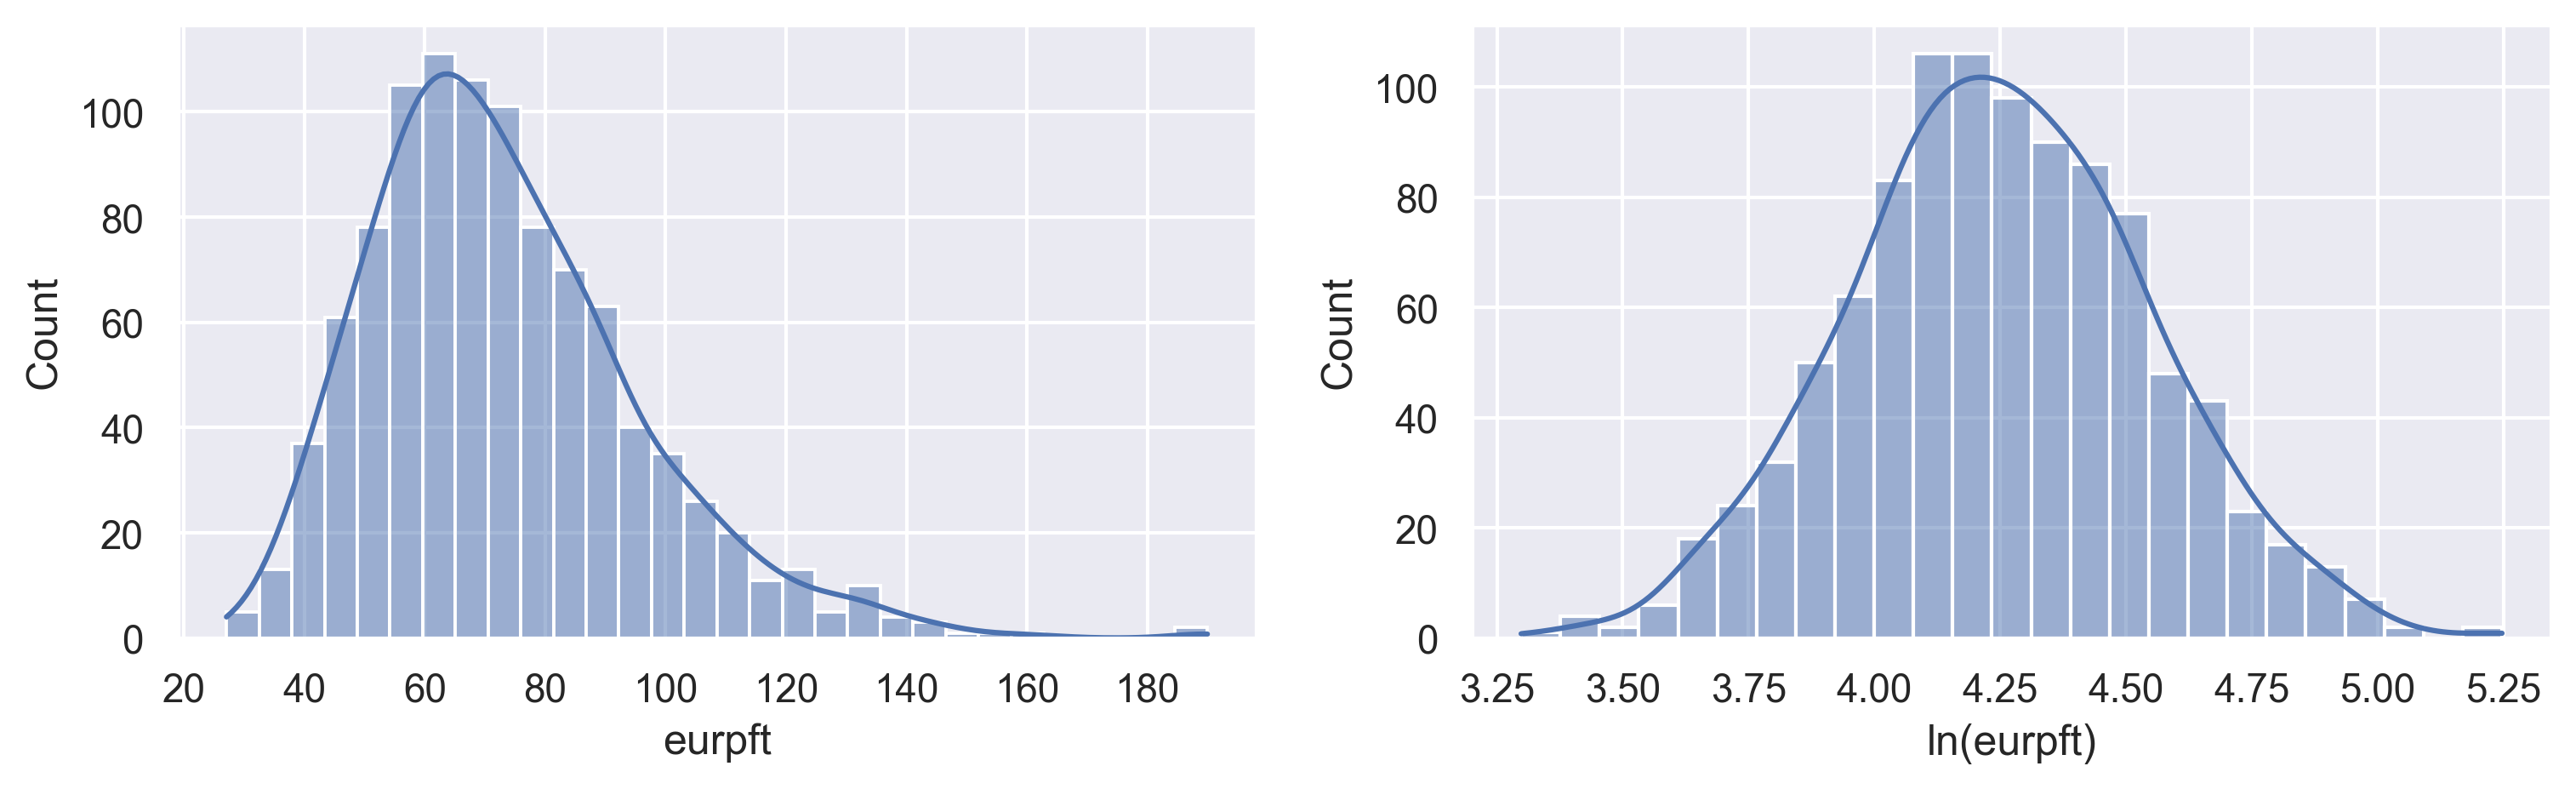

In [9]:
# examine & sense-check distribution of EUR/ft and ln(EUR/ft):

ax1 = plt.subplot(221)
ax1 = sns.histplot(df['eurpft'], kde=True)
ax2 = plt.subplot(222)
ax2 = sns.histplot(np.log(df['eurpft']), kde=True)
ax2.set_xlabel('ln(eurpft)')

Text(0.5, 1.0, 'EUR per vs. Spacing')

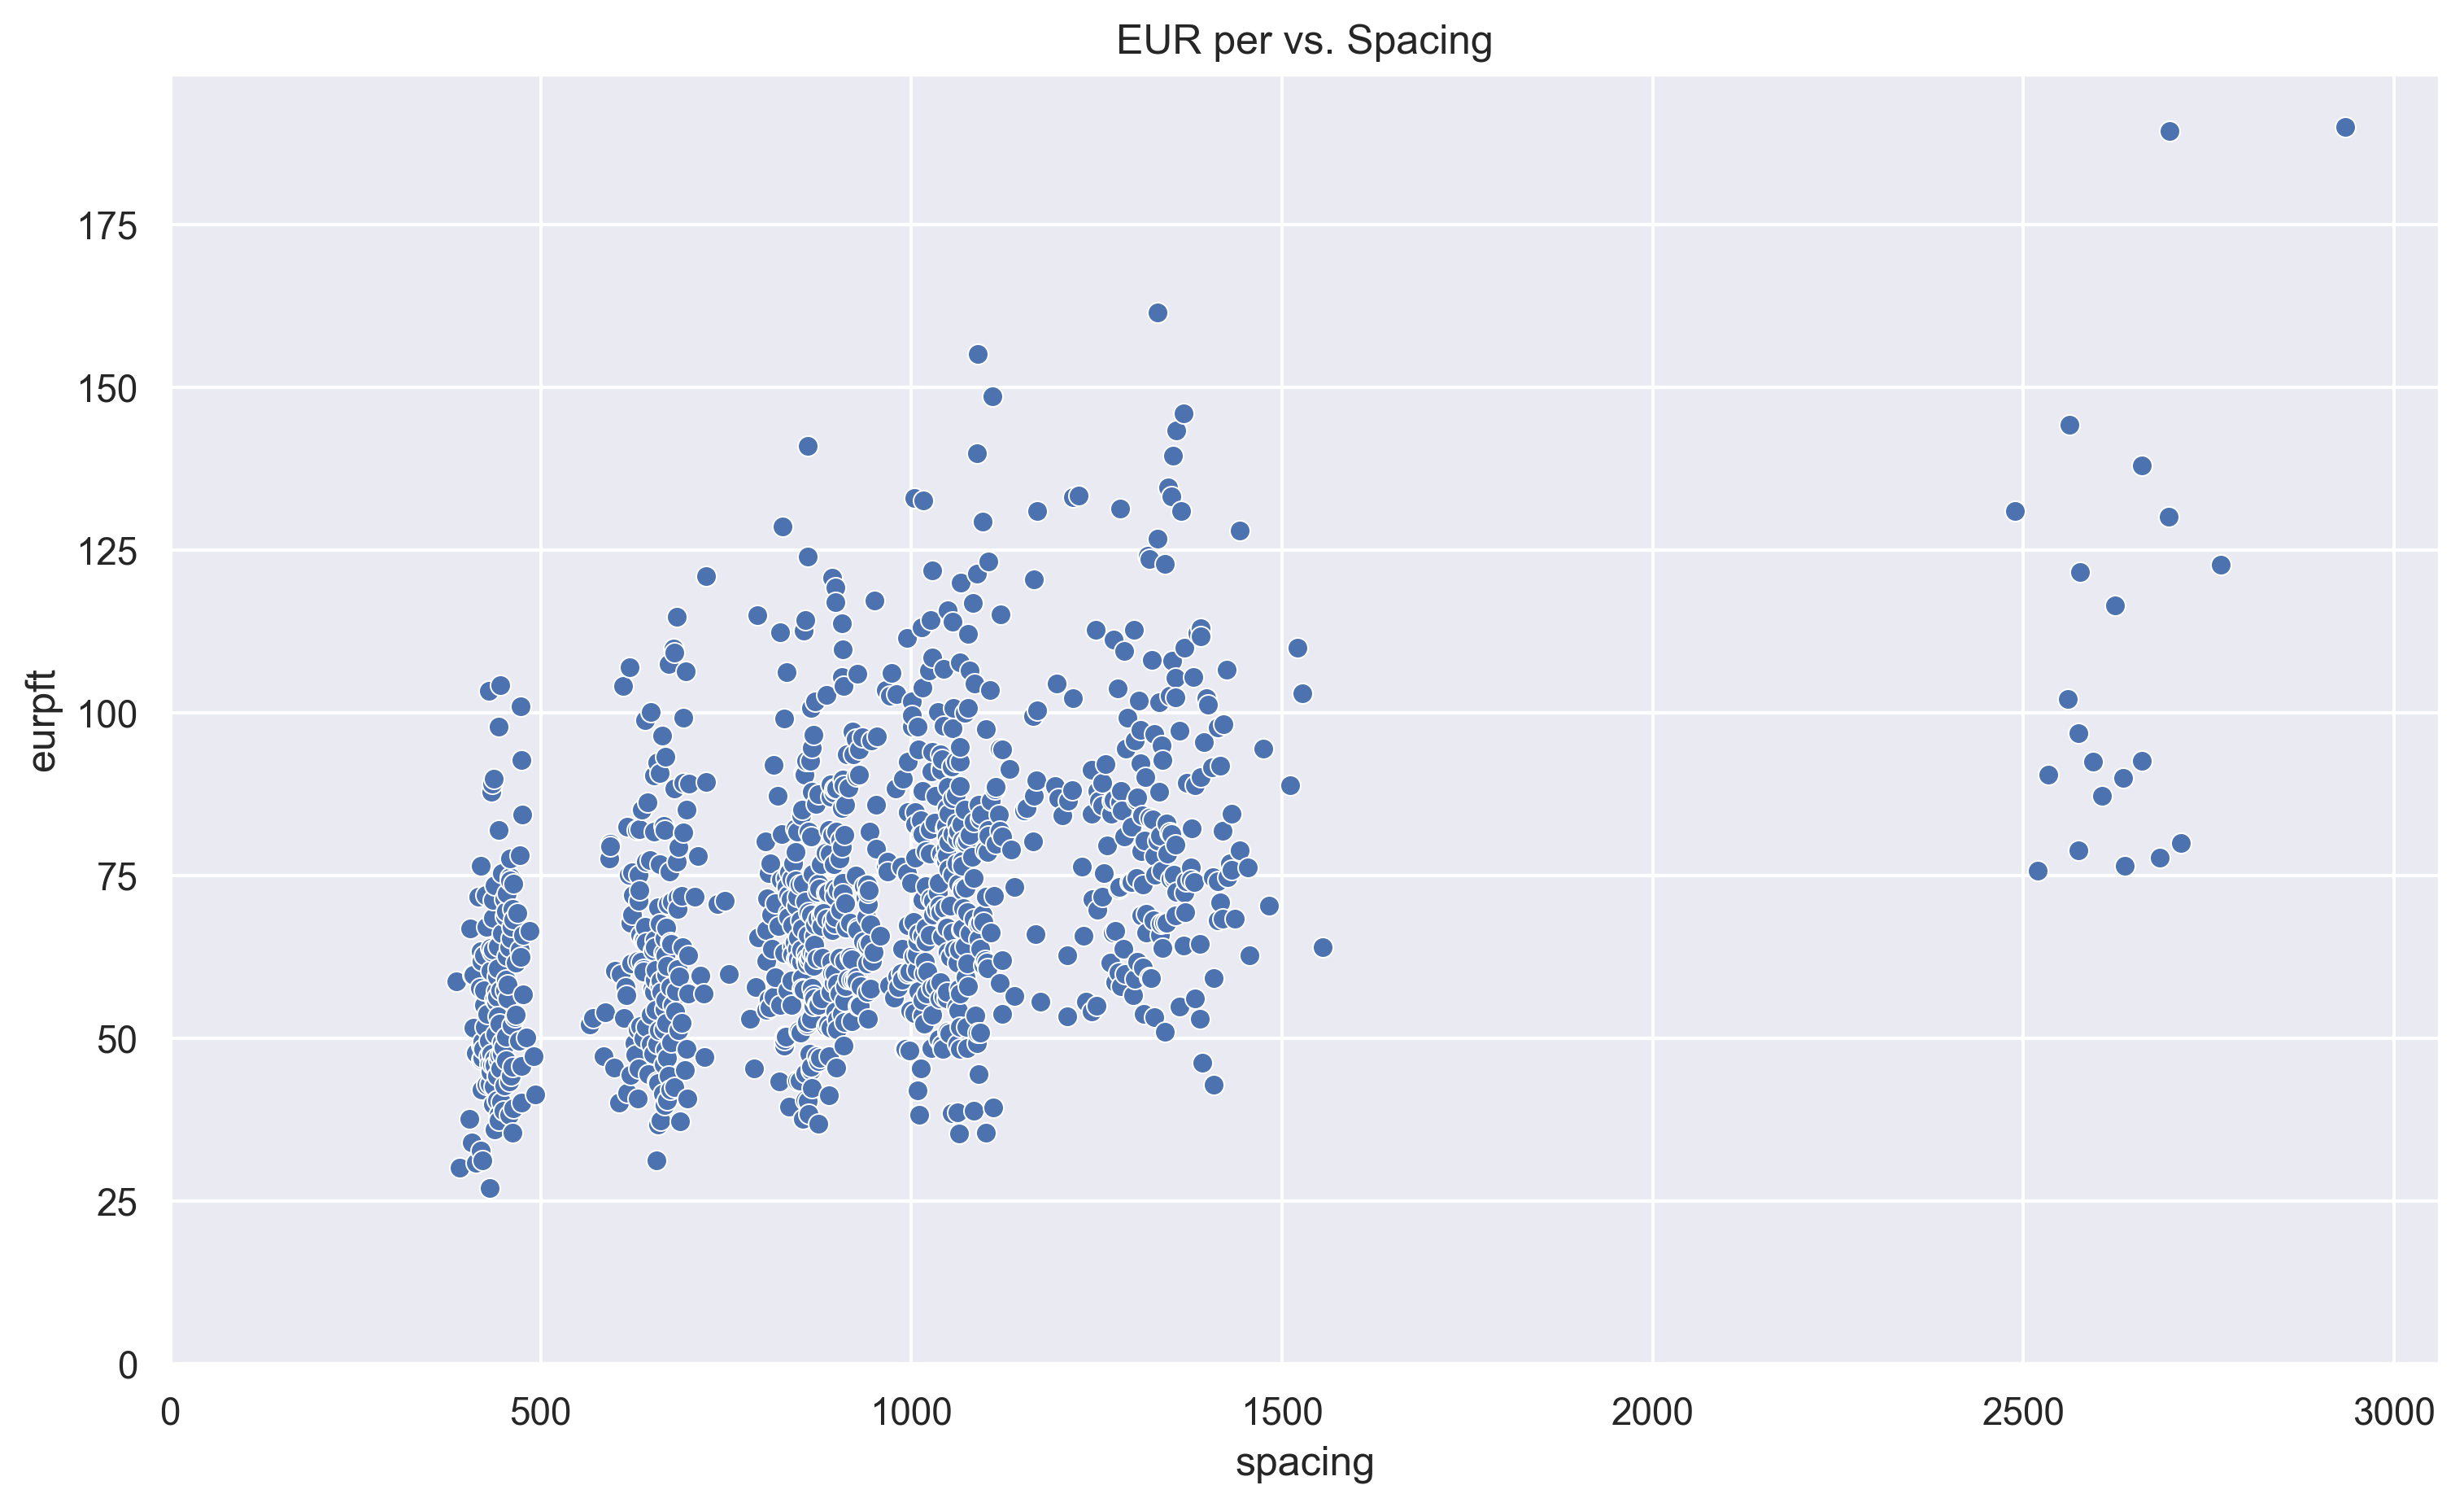

In [11]:
sns.scatterplot(data=df, x='spacing', y='eurpft')
plt.xlim(0, None)
plt.ylim(0, None)
plt.title('EUR per vs. Spacing')

---
### A key observation may be useful here: any subset of the EUR-per-ft data for a fixed spacing (or sampled within a relatively narrow band of spacing values) should be lognormally distributed. This is typically observable in real data with sufficient count.

### However, a simple linearization of the EUR-per-ft vs. spacing relationship (below) is not usually sufficient for the purpose of linear regression, as marked non-linearity typically persists due to non-linearity between recovery factor and spacing, and potentially more exogeneities.
---

Text(0.5, 1.0, 'ln(Eur per Ft) vs. Spacing')

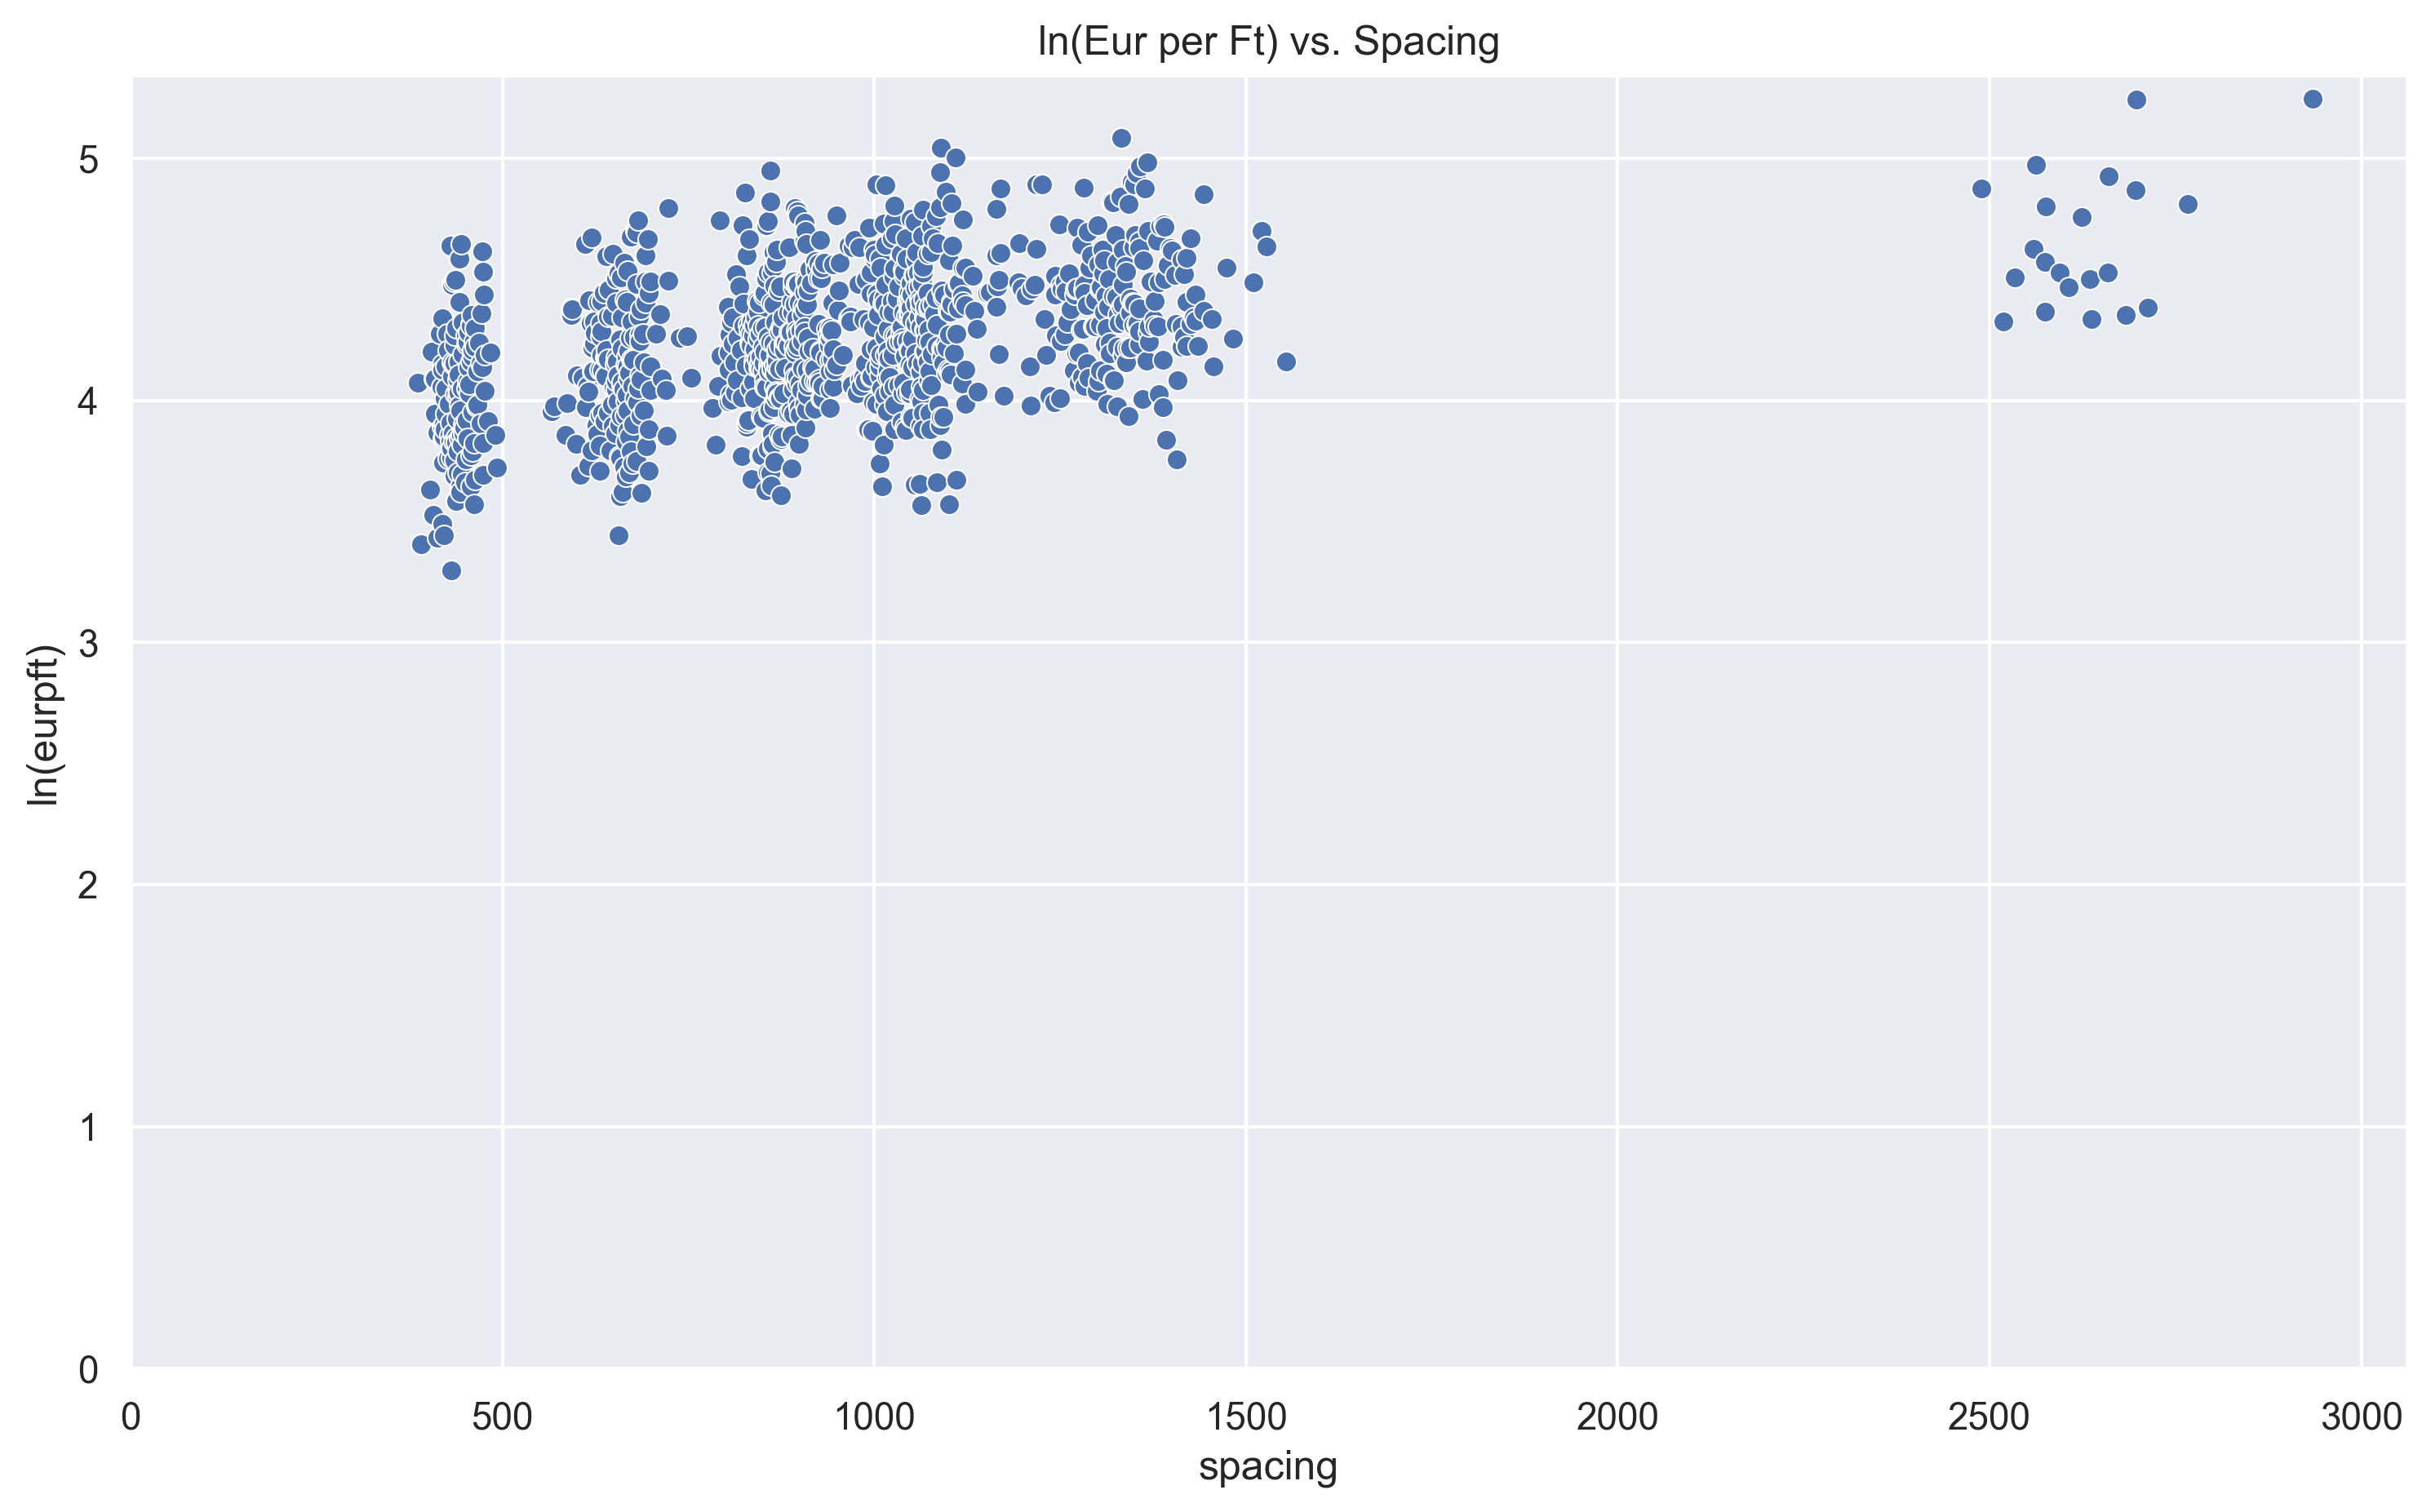

In [12]:
# examine the bivariate relationship between spacing & EUR/ft

ax1 = sns.scatterplot(data=df, x='spacing', y=np.log(df['eurpft']))
plt.xlim(0, None)
plt.ylim(0, None)
plt.ylabel('ln(eurpft)')
plt.title('ln(Eur per Ft) vs. Spacing')

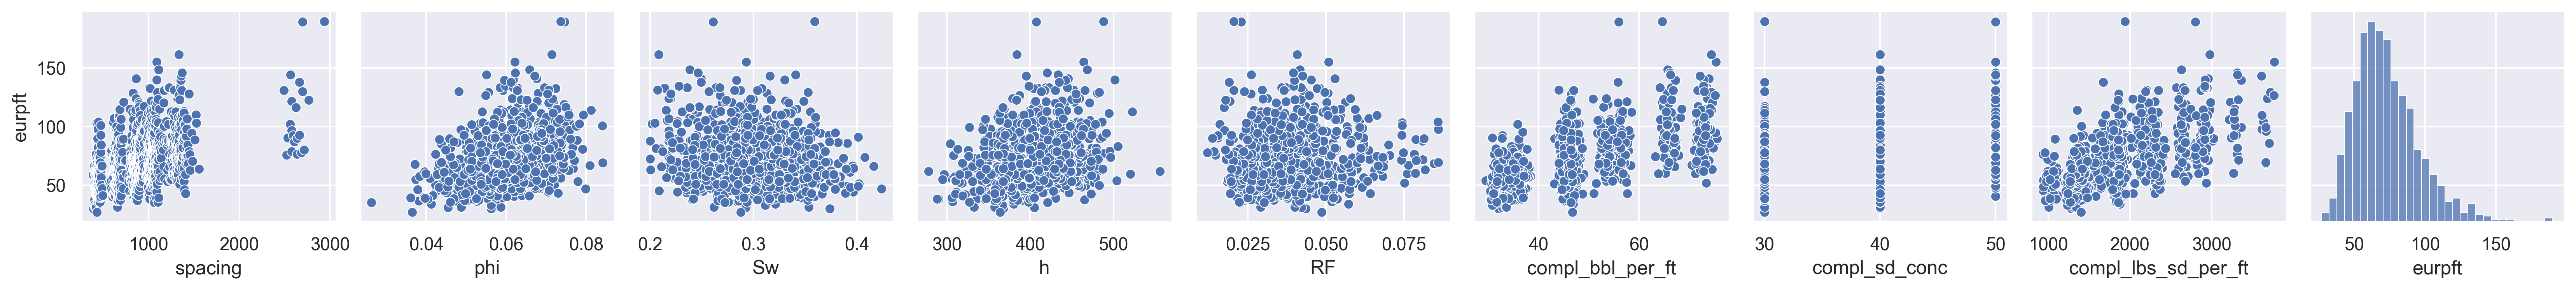

In [13]:
# quick examination of bivariate relationships
sns.pairplot(df, y_vars='eurpft')

### Export the data for use in various modeling/prediction approaches:

In [14]:
# df.to_csv('data.csv')